In [437]:
from scipy.special import sph_harm as Ylm
import matplotlib.pyplot as plt
import numpy as np
from dscribe.descriptors import SOAP
from ase.io import read

In [354]:
def real_Ylm(m, l, phi, theta):
    if m < 0:
        return np.real(np.sqrt(-1+0j) /np.sqrt(2) * (Ylm(m, l, phi, theta) - (-1)**m * Ylm(-m,l, phi, theta) ))
    elif m == 0:
        return np.real(Ylm(0, l, phi, theta))
    else:
        return np.real(1 /np.sqrt(2) * (Ylm(-m, l, phi, theta) + (-1)**m * Ylm(m,l, phi, theta) )        )

def gaussian(x, mu=0, sig=0.3):
    return np.exp(np.sum(-np.power(x - mu, 2.), axis=-1) / (2 * np.power(sig, 2.)))

def smoothed_density(xy_grid, positions, smear):
    density = np.zeros(shape=xy_grid.shape[1:])
    for position in positions:
        density += gaussian(x=np.moveaxis(xy_grid, 0, -1), mu=position, sig=smear)
    return density

# Used in doi.org/10.1002/qua.24927
def cutoff_factor(r, rcut, rcut_thickness=1):
    factor = np.zeros(shape=r.shape)
    factor[np.where(np.abs(rcut - rcut_thickness/2.0 - r) < rcut_thickness/2.0)] = (np.cos(np.pi*(r[np.where(np.abs(rcut - rcut_thickness/2.0 - r) < rcut_thickness/2.0)] - (rcut - rcut_thickness) )/rcut_thickness) + 1)/2
    factor[np.where(r<= rcut-rcut_thickness)] = 1
    return factor

def gto(r, rcut, n, nmax, l, lmax, sigma=0.3):
    soap = SOAP(rcut=rcut, nmax=nmax, lmax=lmax, sigma=sigma, species=["O", "H"])
    alphas, betas = soap.get_basis_gto(rcut=r_max, nmax=nmax, lmax=lmax)
    
    gnl = np.zeros(shape=r.shape)
    for nprime in range(1, nmax + 1):
        gnl += betas[l, nprime - 1, n - 1] * np.power(r, l) * np.exp(- alphas[l, nprime - 1] * np.power(r, 2))
    return gnl

In [454]:
librascal_molecule = read("../data/distorted_propanol_unzipped.extxyz", ":10")#read("../data/C7O2H10_unzipped.extxyz", ":10")



import sys
sys.path.append('../code')
from Visualize_Structures import Structure3DAnimation
Structure3DAnimation(librascal_molecule).Plot()

Generating animation frame 0 (0% complete)
Generating animation frame 10 (10% complete)
Generating animation frame 20 (20% complete)
Generating animation frame 30 (30% complete)
Generating animation frame 40 (40% complete)
Generating animation frame 50 (50% complete)
Generating animation frame 60 (60% complete)
Generating animation frame 70 (70% complete)
Generating animation frame 80 (80% complete)
Generating animation frame 90 (90% complete)
Generating animation frame 100 (100% complete)


[[ 0.        1.395248  0.      ]
 [ 1.20832   0.697624  0.      ]
 [ 1.20832  -0.697624  0.      ]
 [ 0.       -1.395248  0.      ]
 [-1.20832  -0.697624  0.      ]
 [-1.20832   0.697624  0.      ]
 [ 0.        2.48236   0.      ]
 [ 2.149787  1.24118   0.      ]
 [ 2.149787 -1.24118   0.      ]
 [ 0.       -2.48236   0.      ]
 [-2.149787 -1.24118   0.      ]
 [-2.149787  1.24118   0.      ]]
['C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H']
[0. 0. 0.]
[[ 0.        1.395248  0.      ]
 [ 1.20832   0.697624  0.      ]
 [ 1.20832  -0.697624  0.      ]
 [ 0.       -1.395248  0.      ]
 [-1.20832  -0.697624  0.      ]
 [-1.20832   0.697624  0.      ]
 [ 0.        2.48236   0.      ]
 [ 2.149787  1.24118   0.      ]
 [ 2.149787 -1.24118   0.      ]
 [ 0.       -2.48236   0.      ]
 [-2.149787 -1.24118   0.      ]
 [-2.149787  1.24118   0.      ]]


<Axes3DSubplot:>

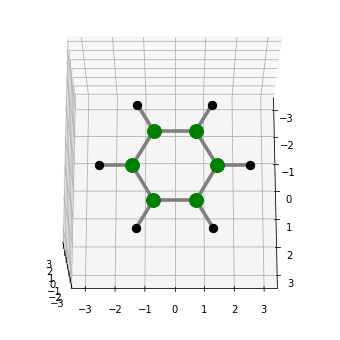

In [501]:
from ase.build import molecule
benzene = molecule("C6H6")
print(benzene.positions)
print(benzene.get_chemical_symbols())
pos = benzene.positions - np.mean(benzene.positions, axis=0) #benzene.positions[5]
print(np.mean(benzene.positions, axis=0))
#pos = np.moveaxis(pos, -1,0)
#pos =np.roll(pos, shift=1, axis=1)
benzene.set_positions(pos)
print(pos)
Structure3DPlot(benzene, no_axis=False, no_grid=False).Plot()

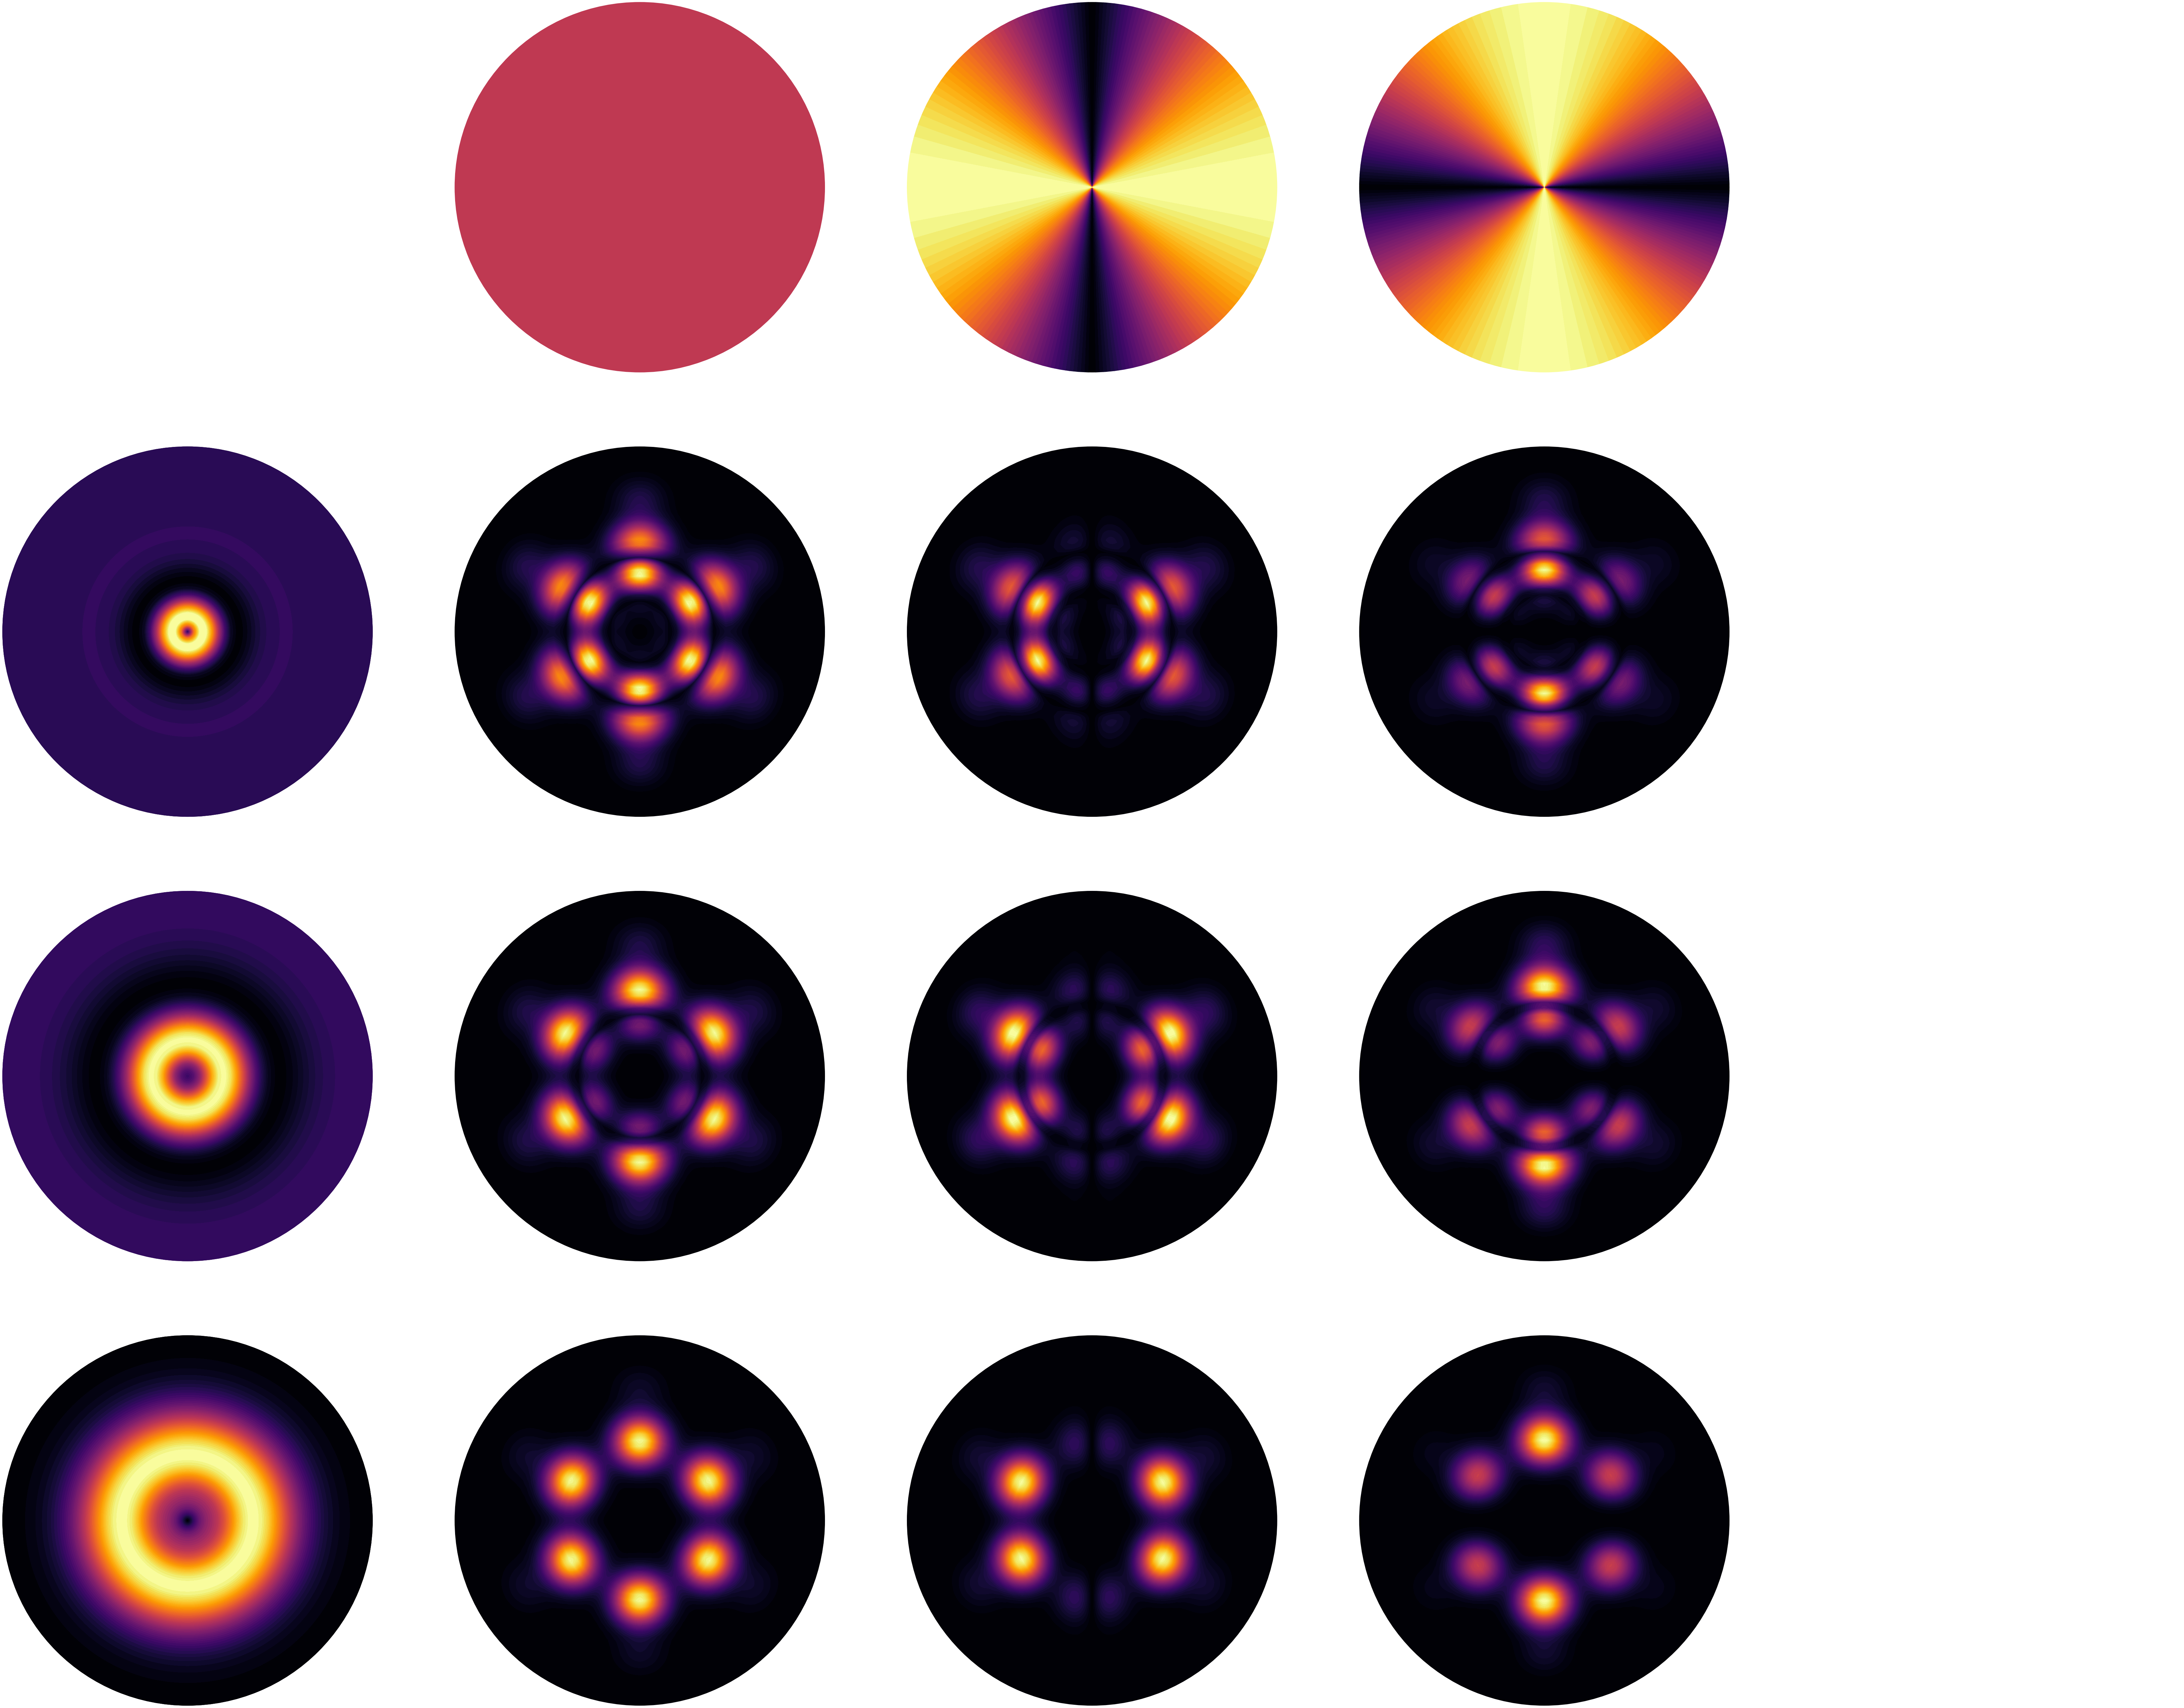

In [564]:
import matplotlib.pyplot as plt
import numpy as np
    
delta_r = 0.1
r_max = 3

nmax=3
lmax=1
rs = np.arange(0, r_max + delta_r, delta_r)

cutoff_factors = cutoff_factor(rs, r_max)

delta_theta = 1 #5 # degrees
delta_theta_radians = delta_theta /360 * 2 * np.pi
thetas = np.arange(0, 2*np.pi + delta_theta_radians, delta_theta_radians)

phis = np.array([0 if theta > np.pi else np.pi for theta in thetas])


r_grid, theta_grid = np.meshgrid(rs, thetas)

cutoff_factor_grid, _ = np.meshgrid(cutoff_factors, thetas)

z_grid = r_grid * np.sin(theta_grid)
x_grid = r_grid * np.cos(theta_grid)
xz_grid = np.array([x_grid, z_grid])

#pos = [ [0,0], [.95, 0], [0.95 * np.cos(104.45/180*np.pi), 0.95 * np.sin(104.45/180*np.pi)] ]
positions = np.array(pos[:,:-1]).reshape(-1,1,2)
density_grid = smoothed_density(xy_grid=xz_grid, positions=positions, smear=0.3)


Ylm_lm_dict = {}
gto_nl_dict = {}
lm_col_dict = {}

ns = range(1, nmax+1)
ls = np.arange(0, lmax + 1)

ncols = (lmax + 1)**2 + 1 
nrows = len(ns) + 1
ax_width = 24 #12
ax_height = 24 #12
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*ax_width, nrows*ax_height), subplot_kw={'projection': 'polar'} )
#axs = axs.flatten()

colormap = plt.get_cmap('inferno')#"inferno")#'gist_ncar')#'nipy_spectral')#"viridis")

n_contours = 60 #6


def radial_grid_plot(ax, z, theta_grid=theta_grid, r_grid=r_grid, n_contours=n_contours, cmap=colormap):
    line = ax.contourf(theta_grid, r_grid, z, n_contours, cmap=colormap)
    return line

column_iterator = 1
for l in ls:
    for m in range(0, l+1):
        #Ylms = #np.sum(np.real(Ylm(m, l, phis, thetas)) ** 2 for m in range(-l, l+1, 1)) 
        #Ylms = real_Ylm(m, l, phis, thetas) # np.real(Ylm(m, l, phis, thetas) * Ylm(-m, l, phis, thetas))#np.abs(Ylm(m, l, 0*phis, thetas)) 
        Ylms = np.abs(Ylm(m, l, phis, thetas))
        _, Ylm_grid = np.meshgrid(rs, Ylms)
        Ylm_lm_dict[(l, m)] =  Ylm_grid
        
        radial_grid_plot(ax=axs[0, column_iterator], z=Ylm_grid)
        lm_col_dict[(l,m)] = column_iterator
        column_iterator +=1        
    
    for n in ns:
        gtos = gto(rs, r_max, n, nmax, l, lmax)
        gto_grid, _ = np.meshgrid(gtos, thetas)
        gto_nl_dict[(n, l)] = gto_grid
        
        radial_grid_plot(ax=axs[n, 0], z=gto_grid)
    
    for m in range(0, l+1):
        for n in ns:
            p_lmn_grid = np.abs(density_grid * cutoff_factor_grid * Ylm_lm_dict[(l,m)]  * gto_nl_dict[(n, l)] )
            
            radial_grid_plot(ax = axs[n, lm_col_dict[(l,m)]], z=p_lmn_grid)

            



# axs[0].contourf(theta_grid, r_grid, density_grid, n_contours, cmap=colormap)
# axs[1].contourf(theta_grid, r_grid, Ylm_grid, n_contours, cmap=colormap)
# axs[2].contourf(theta_grid, r_grid, cutoff_factor_grid, n_contours, cmap=colormap)
# axs[3].contourf(theta_grid, r_grid, gto_grid, n_contours, cmap=colormap)
# axs[4].contourf(theta_grid, r_grid, pnnl_grid, n_contours, cmap=colormap)

# settings used by all axes
axs_flattened = axs.flatten()
for i in range(len(axs_flattened)):
    axs_flattened[i].grid()
    axs_flattened[i].set_yticks([])
    axs_flattened[i].set_xticks([])
    axs_flattened[i].axis("off")

#plt.colorbar(a, ax=axs[:], shrink=0.75)

plt.savefig("../media/SOAP_coefficients")

In [544]:
l_test = 1
m_test =0
n_test = 1
p_test_grid = np.abs(density_grid * cutoff_factor_grid * Ylm_lm_dict[(l_test,m_test)]  * gto_nl_dict[(n_test, l_test)] )

n_contours = 40

fig, axs = plt.subplots( figsize=(ax_width, ax_height), subplot_kw={'projection': 'polar'} )
axs.contourf(theta_grid, r_grid, p_test_grid, n_contours, cmap=colormap)
axs.grid()
axs.set_yticks([])
axs.set_xticks([])
axs.axis("off")

KeyError: (1, 0)

TypeError: Shapes of x (37, 301) and z (145, 61) do not match

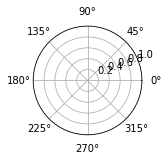

In [546]:
fig, axs = plt.subplots( figsize=(ax_width, ax_height), subplot_kw={'projection': 'polar'} )
axs.contourf(theta_grid, r_grid, p_test_grid, n_contours, cmap=colormap)


In [426]:
Ylm(2, 2, 0, thetas) 

array([0.        +0.j, 0.01164759+0.j, 0.0451855 +0.j, 0.09656855+0.j,
       0.1595992 +0.j, 0.22667501+0.j, 0.28970565+0.j, 0.3410887 +0.j,
       0.37462661+0.j, 0.3862742 +0.j, 0.37462661+0.j, 0.3410887 +0.j,
       0.28970565+0.j, 0.22667501+0.j, 0.1595992 +0.j, 0.09656855+0.j,
       0.0451855 +0.j, 0.01164759+0.j, 0.        +0.j, 0.01164759+0.j,
       0.0451855 +0.j, 0.09656855+0.j, 0.1595992 +0.j, 0.22667501+0.j,
       0.28970565+0.j, 0.3410887 +0.j, 0.37462661+0.j, 0.3862742 +0.j,
       0.37462661+0.j, 0.3410887 +0.j, 0.28970565+0.j, 0.22667501+0.j,
       0.1595992 +0.j, 0.09656855+0.j, 0.0451855 +0.j, 0.01164759+0.j,
       0.        +0.j])

In [418]:
real_Ylm(m, l, 0.15, np.arange(0, 2*np.pi, np.pi/4)) ** 2, real_Ylm(-m, l, 0.15, np.arange(0, 2*np.pi, np.pi/4)) ** 2

(array([0.39788736, 0.02486796, 0.09947184, 0.02486796, 0.39788736,
        0.02486796, 0.09947184, 0.02486796]),
 array([0.39788736, 0.02486796, 0.09947184, 0.02486796, 0.39788736,
        0.02486796, 0.09947184, 0.02486796]))

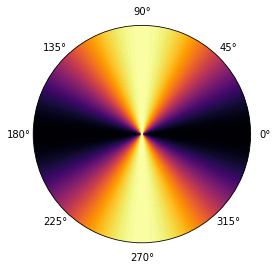

In [205]:
pnnl_grid = density * Ylm_grid

plt.subplot(projection="polar")
#plt.pcolormesh(theta, r, z, shading='gouraud', cmap=colormap)
plt.contourf(theta_grid, r_grid, Ylm_grid, 100, cmap=colormap)
plt.grid(); plt.yticks([]) ;

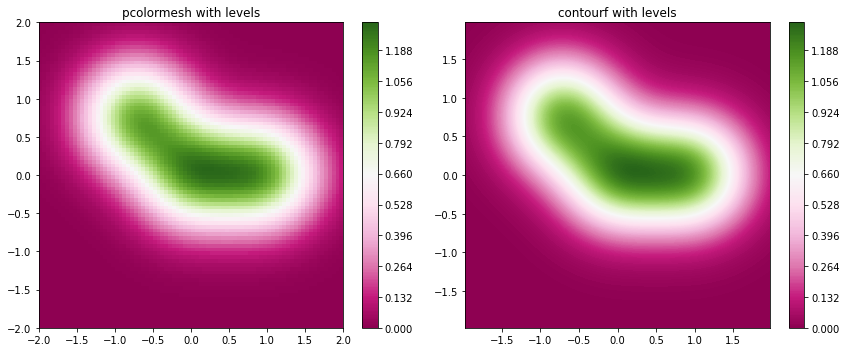

In [184]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np

# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

# generate 2 2d grids for the x & y bounds
xy_grid = np.mgrid[slice(-2, 2 + dx, dx),
                slice(-2, 2 + dy, dy)]

x, y = xy_grid

#z = np.sin(x)**10 + np.cos(10 + y*x) * np.cos(x)
positions = np.array([ [0,0], [.95, 0], [-.75, .75] ]).reshape(-1,1,2)

z = smoothed_density(xy_grid=xy_grid, positions=positions, smear=0.5)

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
levels = MaxNLocator(nbins=256).tick_values(z.min(), z.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')


# contours are *point* based plots, so convert our bound into point
# centers
cf = ax1.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., z, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')

# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
fig.tight_layout()

plt.show()